<div style="background:#FFFFAA">
<img src="nhanes.jpg", width=150, border=20>
<h1>Survival Starting Kit </h1>
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
    <span style="color:red"> Our goal of survival analysis is to predict the expected duration before death for living being. </span>
     <br>
In this challenge we try to tackle a survival analysis problem from a machine learning perspective. The goal of survival analysis is to predict the expected time before a given event occur. In our case we try to estimate the survival time of patients given some data from the NHANES dataset. 
 <br>
    <span style="color:red"> Keep the next block. </span>
</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [2]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_name = 'Mortality'
!ls $data_dir*

Mortality_feat.name      Mortality_test.data      Mortality_train.solution
Mortality_label.name     Mortality_test.solution  Mortality_valid.data
Mortality_public.info    Mortality_train.data     Mortality_valid.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading sample_data/Mortality_train from AutoML format
Number of examples = 19297
Number of features = 11


In [4]:
data.head()

,mortstat,age,sbp,dbp,A1c,bmi,gender_male,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_Other,ethnicity_OtherHispanic,target
0,0.0,50,124.666667,70.000000,5.3,30.74,0,0,0,0,1,132
1,0.0,49,119.333333,72.666667,5.1,23.80,1,0,1,0,0,51
2,0.0,44,134.666667,78.666667,5.9,27.65,1,0,1,0,0,53
3,0.0,50,119.000000,87.000000,4.9,24.77,0,0,1,0,0,75
4,0.0,32,104.666667,72.000000,4.8,26.45,1,0,1,0,0,51


Target = la durée de vie

In [5]:
data.describe() 

,mortstat,age,sbp,dbp,A1c,bmi,gender_male,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_Other,ethnicity_OtherHispanic,target
count,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000
mean,0.097580,46.531793,124.198995,69.418321,5.569762,28.192723,0.483702,0.201275,0.479194,0.037830,0.057315,89.614759
std,0.296754,19.853825,20.062107,13.795536,1.020326,6.261523,0.499747,0.400963,0.499580,0.190789,0.232449,35.847164
min,0.000000,18.000000,72.666667,0.000000,2.000000,12.040000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,29.000000,110.666667,62.000000,5.100000,23.820000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000
50%,0.000000,45.000000,120.000000,70.000000,5.400000,27.260000,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000
75%,0.000000,63.000000,134.000000,77.333333,5.700000,31.470000,1.000000,0.000000,1.000000,0.000000,0.000000,121.000000
max,1.000000,85.000000,270.000000,124.000000,18.800000,76.070000,1.000000,1.000000,1.000000,1.000000,1.000000,153.000000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

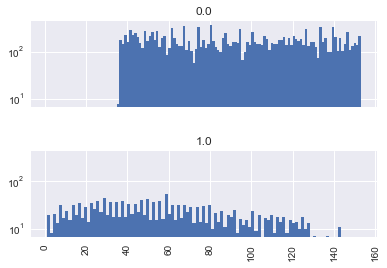

In [31]:
ax=data.hist(column='target', by='mortstat', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

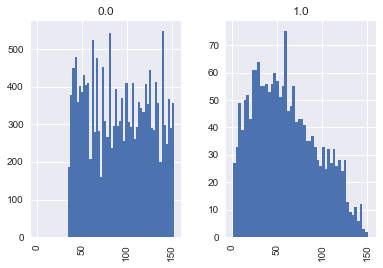

In [35]:
# Mortality by target 
ax = data.hist(column='target', by=['mortstat'], bins=50, sharex=True)

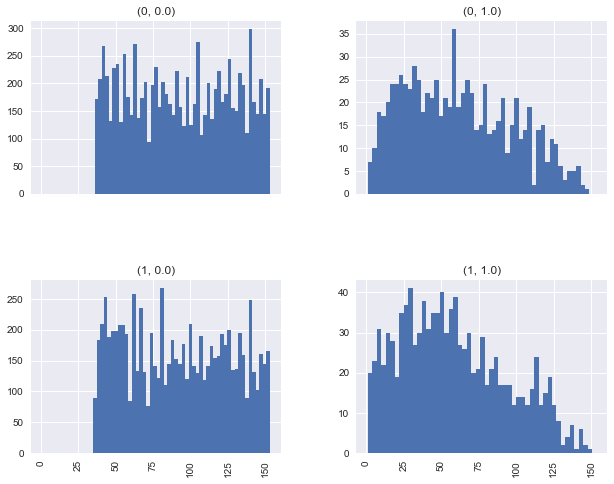

In [38]:
# Lifetime distribution by gender 
ax = data.hist(column='target', by=['gender_male','mortstat'], bins=50
             ,sharex=True, figsize=(10,8))

## Example of regression 

Split into training and validation sets

In [7]:
cox_tr, cox_va = train_test_split(data, test_size=0.2, random_state=15125)

How many deaths did each dataset have?

In [8]:
pd.DataFrame({'training': cox_tr['mortstat'].value_counts(), 'validation': cox_va['mortstat'].value_counts()})

,training,validation
0.0,13929,3485
1.0,1508,375


What does the distribution of survival times look like for the training set?

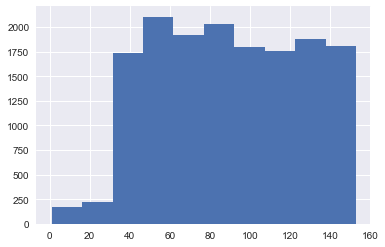

In [9]:
cox_tr['target'].hist()

Train CoxPH model

In [10]:
cox = CoxPHFitter()
cox.fit(cox_tr, duration_col='target', event_col='mortstat', show_progress=True)

Iteration 1: norm_delta = 1.35160, step_size = 0.95000, ll = -13906.26470, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.42984, step_size = 0.95000, ll = -12716.05517, seconds_since_start = 0.6
Iteration 3: norm_delta = 0.19109, step_size = 0.95000, ll = -12394.75041, seconds_since_start = 0.9
Iteration 4: norm_delta = 0.05030, step_size = 0.95000, ll = -12351.21778, seconds_since_start = 1.3
Iteration 5: norm_delta = 0.00520, step_size = 0.95000, ll = -12348.85979, seconds_since_start = 1.5
Iteration 6: norm_delta = 0.00029, step_size = 0.95000, ll = -12348.83658, seconds_since_start = 1.8
Iteration 7: norm_delta = 0.00001, step_size = 0.95000, ll = -12348.83651, seconds_since_start = 2.1
Iteration 8: norm_delta = 0.00000, step_size = 0.95000, ll = -12348.83651, seconds_since_start = 2.4
Convergence completed after 8 iterations.


<lifelines.CoxPHFitter: fitted with 15437 observations, 13929 censored>

Print summary

In [11]:
cox.print_summary()

n=15437, number of events=1508

                              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
age                         0.0796     1.0828    0.0023 34.2788 0.0000      0.0750      0.0841  ***
sbp                         0.0054     1.0054    0.0012  4.4266 0.0000      0.0030      0.0078  ***
dbp                        -0.0061     0.9940    0.0015 -3.9911 0.0001     -0.0090     -0.0031  ***
A1c                         0.1362     1.1460    0.0197  6.9214 0.0000      0.0977      0.1748  ***
bmi                        -0.0129     0.9871    0.0052 -2.5019 0.0124     -0.0231     -0.0028    *
gender_male                 0.4604     1.5847    0.0532  8.6559 0.0000      0.3561      0.5646  ***
ethnicity_NonHispanicBlack  0.4203     1.5225    0.0913  4.6036 0.0000      0.2414      0.5993  ***
ethnicity_NonHispanicWhite  0.2975     1.3465    0.0784  3.7932 0.0001      0.1438      0.4513  ***
ethnicity_Other            -0.0699     0.9325    0.1984 -0.3523 0.72

Visualize feature coefficients and their significance

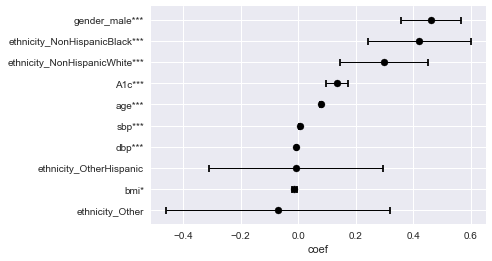

In [12]:
cox.plot()

We see that, given all included features, all features except `ethnicity_Other` and `ethnicity_OtherHispanic` have a significant association with mortality.

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [13]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_data/Mortality_public.info
DataManager : Mortality
info:
	usage = Continuous NHANES Mortality data
	name = mortality
	task = regression
	target_type = Numerical
	feat_type = Numerical
	metric = mse_metric
	time_budget = 1200
	feat_num = 11
	target_num = 1
	label_num = 2
	train_num = 19297
	valid_num = 2171
	test_num = 2412
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(19297, 11)
	Y_train = array(19297,)
	X_valid = array(2413, 11)
	Y_valid = array(2413,)
	X_test = array(2412, 11)
	Y_test = array(2412,)
feat_type:	array(11,)
feat_idx:	array(0,)



<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [14]:
from data_io import write
from model import model
import pickle
import numpy as np   # We recommend to use numpy arrays
from os.path import isfile
from sklearn.base import BaseEstimator

class model (BaseEstimator):
    def __init__(self):
        '''
        This constructor is supposed to initialize data members.
        Use triple quotes for function documentation. 
        '''
        self.num_train_samples=0
        self.num_feat=1
        self.num_labels=1
        self.is_trained=False

    def fit(self, X, y):
        '''
        This function should train the model parameters.
        Here we do nothing in this example...
        Args:
            X: Training data matrix of dim num_train_samples * num_feat.
            y: Training label matrix of dim num_train_samples * num_labels.
        Both inputs are numpy arrays.
        For classification, labels could be either numbers 0, 1, ... c-1 for c classe
        or one-hot encoded vector of zeros, with a 1 at the kth position for class k.
        The AutoML format support on-hot encoding, which also works for multi-labels problems.
        Use data_converter.convert_to_num() to convert to the category number format.
        For regression, labels are continuous values.
        '''
        self.num_train_samples = X.shape[0]
        if X.ndim>1: self.num_feat = X.shape[1]
        print("FIT: dim(X)= [{:d}, {:d}]".format(self.num_train_samples, self.num_feat))
        num_train_samples = y.shape[0]
        if y.ndim>1: self.num_labels = y.shape[1]
        print("FIT: dim(y)= [{:d}, {:d}]".format(num_train_samples, self.num_labels))
        if (self.num_train_samples != num_train_samples):
            print("ARRGH: number of samples in X and y do not match!")
        self.is_trained=True

    def predict(self, X):
        '''
        This function should provide predictions of labels on (test) data.
        Here we just return zeros...
        Make sure that the predicted values are in the correct format for the scoring
        metric. For example, binary classification problems often expect predictions
        in the form of a discriminant value (if the area under the ROC curve it the metric)
        rather that predictions of the class labels themselves. For multi-class or multi-labels
        problems, class probabilities are often expected if the metric is cross-entropy.
        Scikit-learn also has a function predict-proba, we do not require it.
        The function predict eventually can return probabilities.
        '''
        num_test_samples = X.shape[0]
        if X.ndim>1: num_feat = X.shape[1]
        print("PREDICT: dim(X)= [{:d}, {:d}]".format(num_test_samples, num_feat))
        if (self.num_feat != num_feat):
            print("ARRGH: number of features in X does not match training data!")
        print("PREDICT: dim(y)= [{:d}, {:d}]".format(num_test_samples, self.num_labels))
        y = np.zeros([num_test_samples, self.num_labels])
        # If you uncomment the next line, you get pretty good results for the Iris data :-)
        #y = np.round(X[:,3])
        return y

    def save(self, path="./"):
        pickle.dump(self, open(path + '_model.pickle', "wb"))

    def load(self, path="./"):
        modelfile = path + '_model.pickle'
        if isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        return self
 

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [15]:
M = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
M = M.load(trained_model_name)    
print(M.is_trained)

Model reloaded from: sample_code_submission/Mortality_model.pickle
True


<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [16]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']
if not(M.is_trained):
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

PREDICT: dim(X)= [19297, 11]
PREDICT: dim(y)= [19297, 1]
PREDICT: dim(X)= [2413, 11]
PREDICT: dim(y)= [2413, 1]
PREDICT: dim(X)= [2412, 11]
PREDICT: dim(y)= [2412, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [17]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/Mortality_test.predict
sample_result_submission/Mortality_train.predict
sample_result_submission/Mortality_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [18]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric


Using scoring metric: mse_metric


In [19]:
from sys import argv
import libscores
import my_metric
import yaml
from libscores import *
import os

solution_dir = 'sample_data'

# Debug flag 0: no debug, 1: show all scores, 2: also show version amd listing of dir
debug_mode = 0

# Constant used for a missing score
missing_score = -0.999999

# Version number
scoring_version = 1.0

# Create the output directory, if it does not already exist and open output files
mkdir(score_dir)
print(os.getcwd())
score_file = open(os.getcwd() + '/scores.txt', 'w')
html_file = open(os.getcwd() + '/scores.html', 'w')


# Get all the solution files from the solution directory
solution_names = sorted(ls(os.path.join(solution_dir, '*.solution')))
print(solution_names)

# Loop over files in solution directory and search for predictions with extension .predict having the same basename
for i, solution_file in enumerate(solution_names):
    set_num = i + 1  # 1-indexed
    score_name = 'set%s_score' % set_num

    # Extract the dataset name from the file name
    basename = solution_file[-solution_file[::-1].index(filesep):-solution_file[::-1].index('.') - 1]

    try:
        # Get the last prediction from the res subdirectory (must end with '.predict')
        predict_file = ls(os.path.join(prediction_dir, basename + '*.predict'))[-1]
        if (predict_file == []): raise IOError('Missing prediction file {}'.format(basename))
        predict_name = predict_file[-predict_file[::-1].index(filesep):-predict_file[::-1].index('.') - 1]
        # Read the solution and prediction values into numpy arrays
        solution = read_array(solution_file)
        prediction = read_array(predict_file)
        if (solution.shape != prediction.shape): 
            solution = convert_to_num(solution) 
        if (solution.shape != prediction.shape): 	
            raise ValueError("Prediction shape={} instead of Solution shape={}".format(prediction.shape, solution.shape))

        try:
            # Compute the score prescribed by the metric file 
            score = scoring_function(solution, prediction)
            print(
                "======= Set %d" % set_num + " (" + predict_name.capitalize() + "): " + metric_name + "(" + score_name + ")=%0.12f =======" % score)
            html_file.write(
                "<pre>======= Set %d" % set_num + " (" + predict_name.capitalize() + "): " + metric_name + "(" + score_name + ")=%0.12f =======\n" % score)
        except:
            raise Exception('Error in calculation of the specific score of the task')

        if debug_mode > 0:
            scores = compute_all_scores(solution, prediction)
            write_scores(html_file, scores)

    except Exception as inst:
        score = missing_score
        print(
            "======= Set %d" % set_num + " (" + basename.capitalize() + "): " + metric_name + "(" + score_name + ")=ERROR =======")
        html_file.write(
            "======= Set %d" % set_num + " (" + basename.capitalize() + "): " + metric_name + "(" + score_name + ")=ERROR =======\n")
        print
        inst

    # Write score corresponding to selected task and metric to the output file
    score_file.write(score_name + ": %0.12f\n" % score)

# End loop for solution_file in solution_names

# Read the execution time and add it to the scores:
try:
    metadata = yaml.load(open(os.path.join(input_dir, 'res', 'metadata'), 'r'))
    score_file.write("Duration: %0.6f\n" % metadata['elapsedTime'])
except:
    score_file.write("Duration: 0\n")

    html_file.close()
score_file.close()

# Lots of debug stuff
if debug_mode > 1:
    swrite('\n*** SCORING PROGRAM: PLATFORM SPECIFICATIONS ***\n\n')
    show_platform()
    show_io(prediction_dir, score_dir)
    show_version(scoring_version)


/Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival
['sample_data/Mortality_test.solution', 'sample_data/Mortality_train.solution', 'sample_data/Mortality_valid.solution']
======= Set 1 (Mortality_test): mse_metric(set1_score)=ERROR =======
======= Set 2 (Mortality_train): mse_metric(set2_score)=ERROR =======
======= Set 3 (Mortality_valid): mse_metric(set3_score)=ERROR =======


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [20]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the mse_metric metric = 9315.7576
Ideal score for the mse_metric metric = 0.0000


You can add here other scores and result visualization.

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  4,   0,   0, ...,   0,   0,   0],
       [ 15,   0,   0, ...,   0,   0,   0],
       ..., 
       [140,   0,   0, ...,   0,   0,   0],
       [154,   0,   0, ...,   0,   0,   0],
       [ 64,   0,   0, ...,   0,   0,   0]])

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [22]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [15437, 11]
FIT: dim(y)= [15437, 1]
PREDICT: dim(X)= [3860, 11]
PREDICT: dim(y)= [3860, 1]
FIT: dim(X)= [15437, 11]
FIT: dim(y)= [15437, 1]
PREDICT: dim(X)= [3860, 11]
PREDICT: dim(y)= [3860, 1]
FIT: dim(X)= [15438, 11]
FIT: dim(y)= [15438, 1]
PREDICT: dim(X)= [3859, 11]
PREDICT: dim(y)= [3859, 1]
FIT: dim(X)= [15438, 11]
FIT: dim(y)= [15438, 1]
PREDICT: dim(X)= [3859, 11]
PREDICT: dim(y)= [3859, 1]
FIT: dim(X)= [15438, 11]
FIT: dim(y)= [15438, 1]
PREDICT: dim(X)= [3859, 11]
PREDICT: dim(y)= [3859, 1]

CV score (95 perc. CI): 9315.77 (+/- 173.69)


<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [23]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Could not find conda environment: python3
You can list all discoverable environments with `conda info --envs`.

Using input_dir: /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_data
Using output_dir: /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_result_submission
Using program_dir: /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/ingestion_program
Using submission_dir: /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Mortality ********
************************************************
========= Reading and converting data ==========
Info file found : /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_data/Mortality_public.info
========= Reading /Users/nour/Desktop/AIC/mini_projet/23/projet_AIC_Survival/sample_data/Mortality_feat.type
[+] Success in  0.00 sec
=======

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [24]:
scoring_output_dir = '../scoring_output_dir'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

Could not find conda environment: python3
You can list all discoverable environments with `conda info --envs`.

======= Set 1 (Mortality_test): mse_metric(set1_score)=2254.239220563848 =======
======= Set 2 (Mortality_train): mse_metric(set2_score)=0.000000000000 =======
======= Set 3 (Mortality_valid): mse_metric(set3_score)=2268.631993369250 =======


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [33]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_18-11-21-23-08.zip
../sample_result_submission_18-11-21-23-08.zip
